In [18]:
import os
from subprocess import call
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,
                             mean_squared_log_error, median_absolute_error)
from sklearn.preprocessing import StandardScaler
from dataset_reader import get_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/rajala/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
# Load dataset
df = get_dataset()
df = df.drop('id', axis=1)
print(f"Dataset size: {df.shape[0]} rows")
print(f"Columns: {list(df.columns)}")

Reading profile JSONs
Filtered out 268 profiles
Labeled dataset size: 50
Dataset size: 50 rows
Columns: ['verified', 'name_len', 'followers_count', 'following_count', 'tweet_count', 'listed_count', 'has_url', 'created_at', 'desc_len', 'desc_words', 'following_followers_ratio', 'tweet.length_mean', 'tweet.words_mean', 'tweet.retweets_mean', 'tweet.replies_mean', 'tweet.likes_mean', 'tweet.quotes_mean', 'tweet.mentions_mean', 'tweet.retweets_percentage', 'tweet.sentiment.total', 'tweet.sentiment.pos', 'tweet.sentiment.neg', 'tweet.sentiment.neu', 'credibility_score']


In [20]:
# Split dataset for test and train sets
dataset_df = df.dropna()

train_df, test_df = train_test_split(dataset_df, train_size=0.8)
y_variable = "credibility_score"
train_x = train_df.drop(y_variable, axis=1)
test_x = test_df.drop(y_variable, axis=1)
train_y = train_df[y_variable].astype(int)
test_y = test_df[y_variable].astype(int)

print(f"Training data rows: {train_df.shape[0]}")
print(f"Test data rows: {test_df.shape[0]}")

Training data rows: 40
Test data rows: 10


In [21]:
# Train model
model = RandomForestRegressor(n_estimators=10)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x.columns)
model.fit(train_x_scaled, train_y)
prediction = model.predict(test_x_scaled)

/home/rajala/uni/ACP2-Twitter-Profile-Scoring/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [22]:
# Calculate errors

test_y_np = test_y.to_numpy()
test_mse = mean_squared_error(test_y_np, prediction)
test_msle = mean_squared_log_error(test_y_np, prediction)
test_mdae = median_absolute_error(test_y_np, prediction)
test_mae = mean_absolute_error(test_y_np, prediction)
test_mape = mean_absolute_percentage_error(test_y_np, prediction)
print(f"Mean squared error: {test_mse}")
print(f"Mean squared log error: {test_msle}")
print(f"Median absolute error: {test_mdae}")
print(f"Mean absolute error: {test_mae}")
print(f"Mean absolute percentage error {test_mape}")

Mean squared error: 0.708
Mean squared log error: 0.04587368036397671
Median absolute error: 0.75
Mean absolute error: 0.72
Mean absolute percentage error 0.24083333333333332


/home/rajala/uni/ACP2-Twitter-Profile-Scoring/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rajala/uni/ACP2-Twitter-Profile-Scoring/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rajala/uni/ACP2-Twitter-Profile-Scoring/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rajala/uni/ACP2-Twitter-Profile-Scoring/.venv/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/home/rajala/uni/ACP2-Twitter-Profile-Scoring/.venv/lib/python3.8/site-packages/sklearn/base.py:445: Use

IMP:tweet.sentiment.total       -0.167000
listed_count                -0.151333
tweet.likes_mean            -0.052333
tweet.sentiment.neg         -0.050333
following_followers_ratio   -0.038667
tweet.words_mean            -0.033000
tweet.length_mean           -0.010000
followers_count             -0.009667
tweet.retweets_mean          0.000000
verified                     0.000000
has_url                      0.000000
following_count              0.000000
tweet.sentiment.pos          0.004333
tweet.sentiment.neu          0.015500
tweet.retweets_percentage    0.020667
name_len                     0.023500
desc_words                   0.040333
tweet.quotes_mean            0.042500
tweet_count                  0.054667
created_at                   0.067000
desc_len                     0.100333
tweet.mentions_mean          0.105833
tweet.replies_mean           0.155167
dtype: float64
STD: [0.         0.02401909 0.01947648 0.         0.05321236 0.17722835
 0.         0.06497777 0.04765501 0

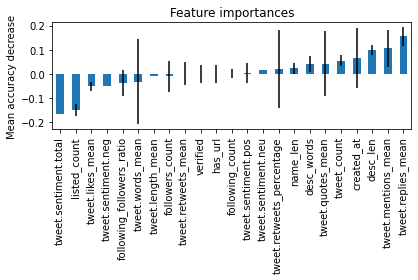

In [23]:
# Feature importances

feature_names = list(dataset_df.columns)
feature_names.remove(y_variable)

# estimator = model.estimators_[5]
# def get_feature_importances(estimator):
#     importances = []
#     for i, feature_name in enumerate(feature_names):
#         importances.append(
#             {"importance": estimator.feature_importances_[i], "feature_name": feature_name})
#     importances = sorted(importances, key=lambda x: x["importance"], reverse=True)
#     return importances

# importances = get_feature_importances(estimator)
# importance_msg = "\n".join(f"{i['feature_name']}: {i['importance']:.3f}" for i in importances)
# print(importance_msg)

from sklearn.inspection import permutation_importance

perm_imp = permutation_importance(
    model, test_x_scaled, test_y, n_repeats=10, n_jobs=2
)
forest_importances = pd.Series(perm_imp.importances_mean, index=feature_names)
forest_importances = forest_importances.sort_values()
print("IMP:" + str(forest_importances))
print("STD: " + str(perm_imp.importances_std))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=perm_imp.importances_std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [24]:
# Save model
import pickle

# Uncomment to update saved model
#pickle.dump(model, open('model/model.pkl', 'wb'))
#pickle.dump(scaler, open('model/scaler.pkl', 'wb'))

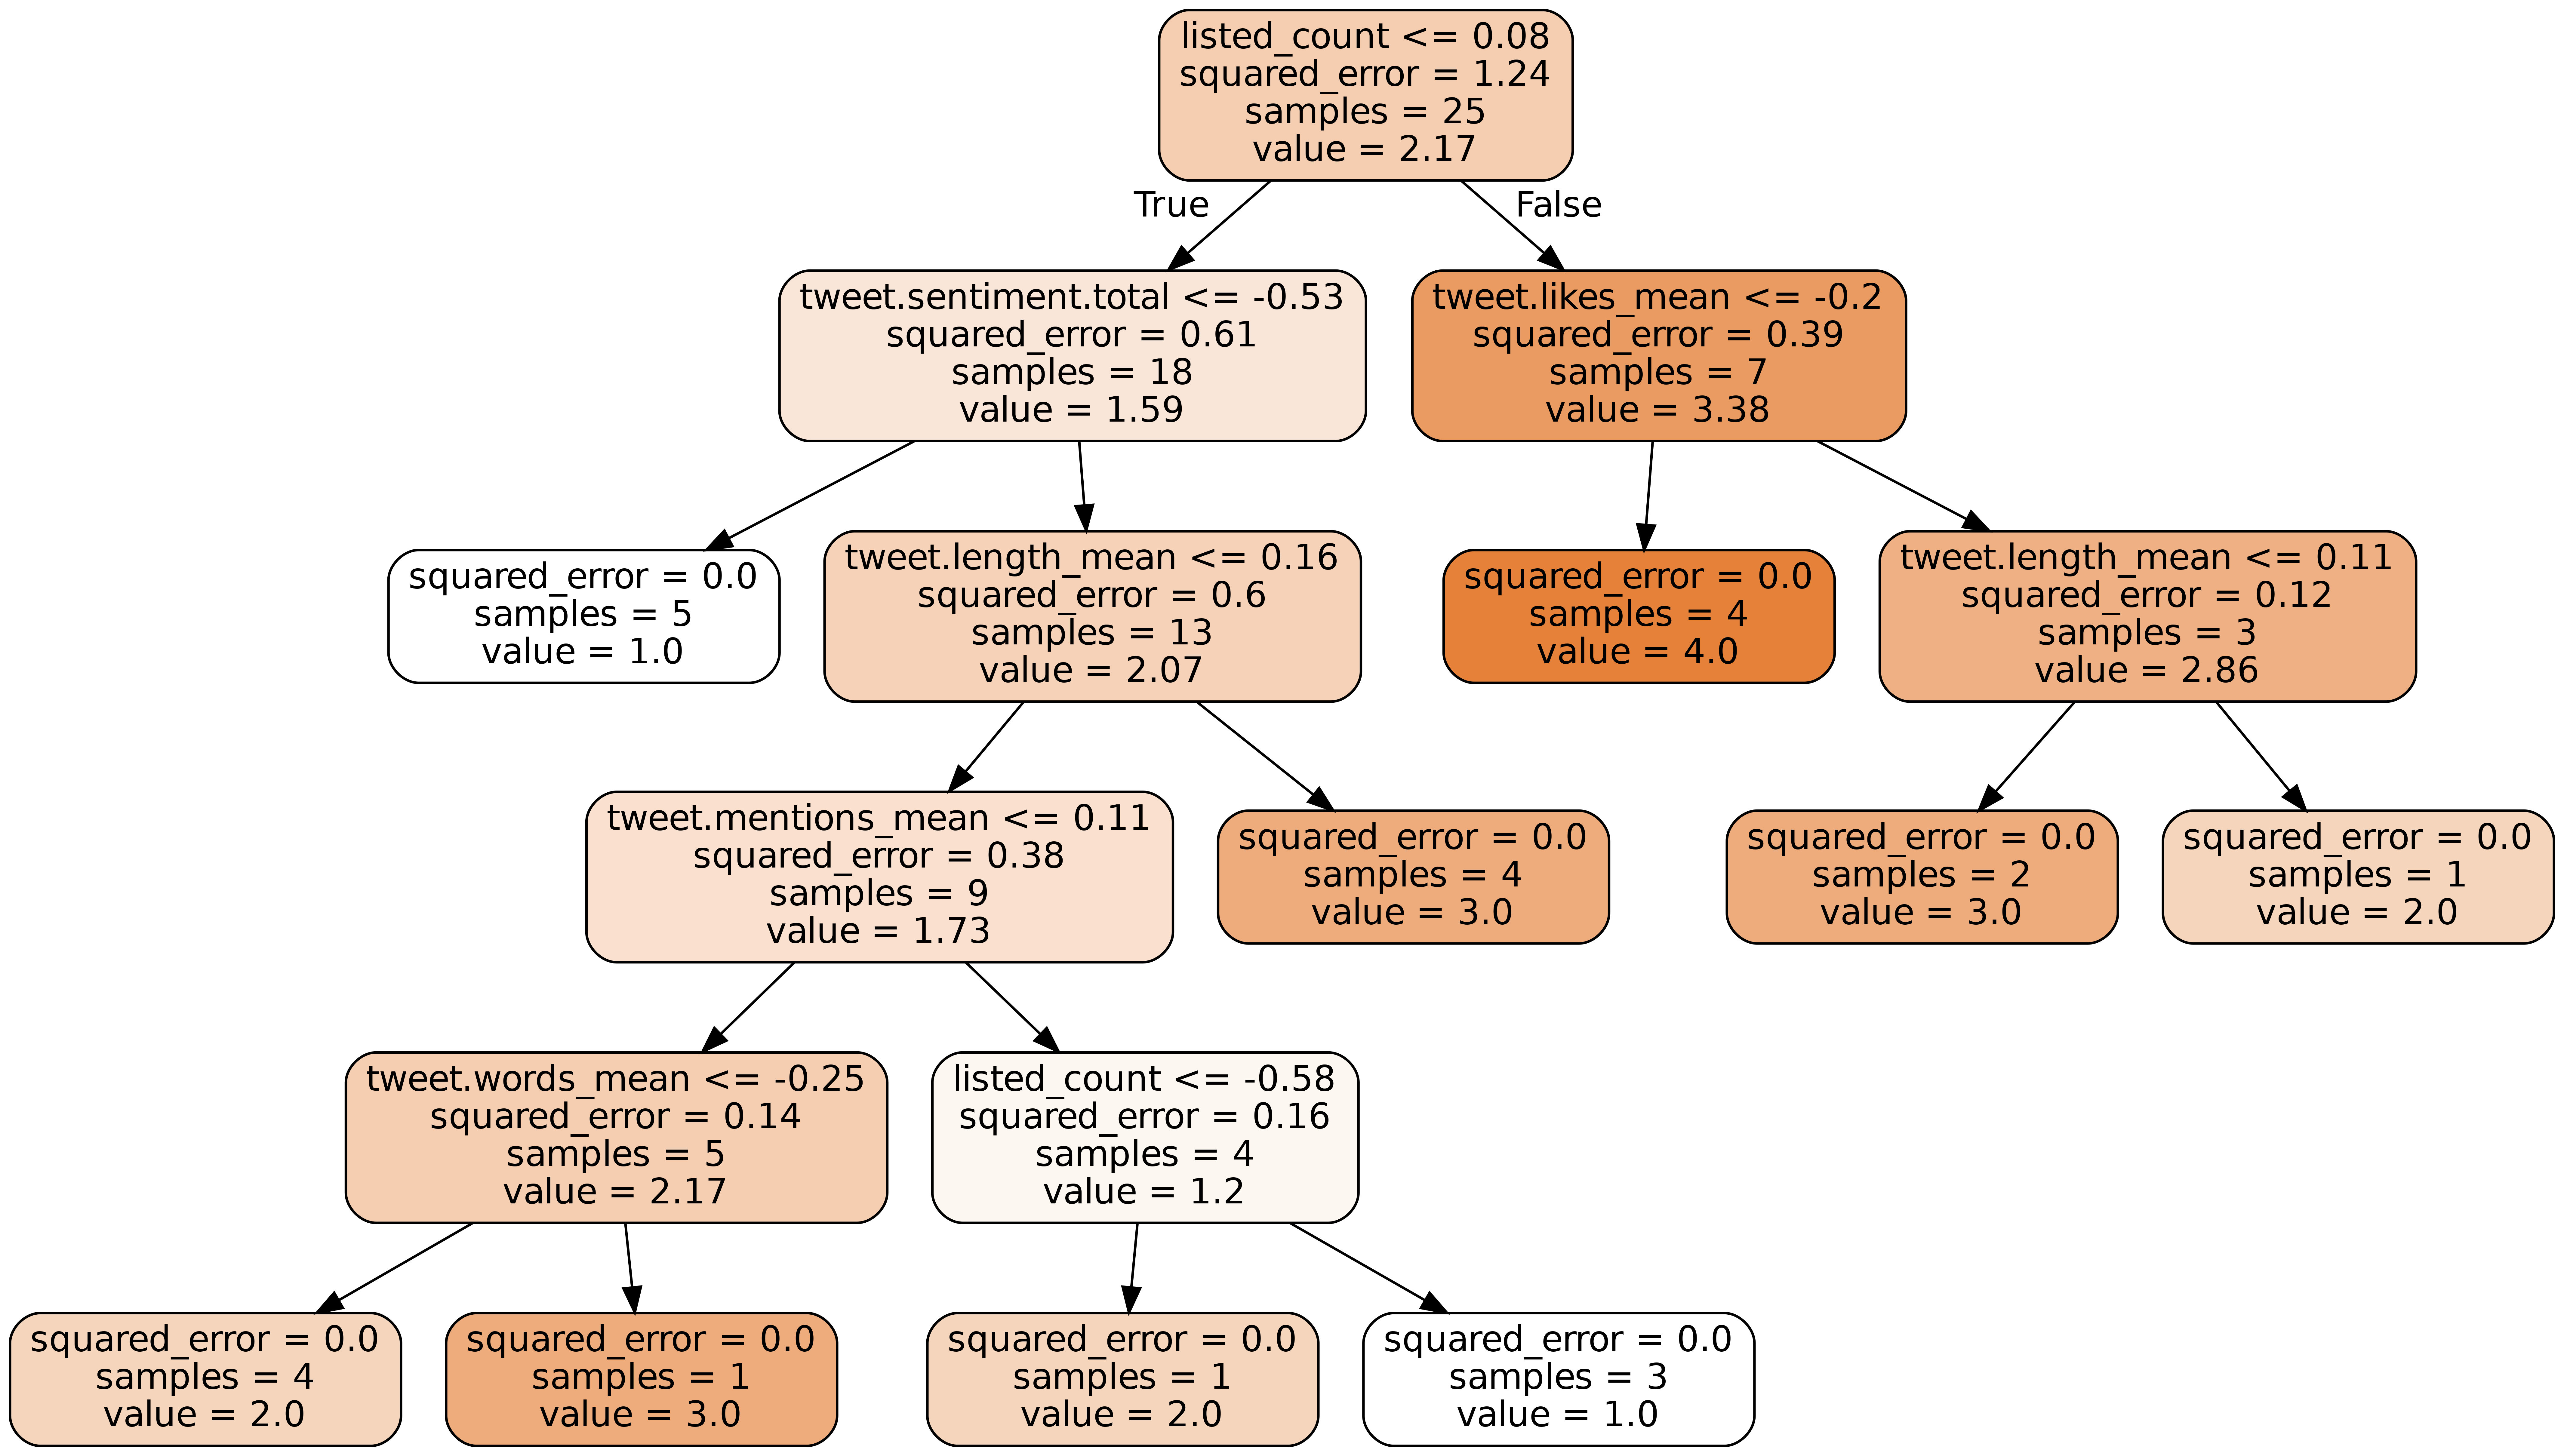

In [25]:
# Visualize tree

estimator = model.estimators_[5]

tmp_dir = os.path.join(os.getcwd(), 'tmp')
if not os.path.isdir(tmp_dir):
    os.mkdir(tmp_dir)
graph_file = os.path.join(tmp_dir, 'tree.dot')
png_file = os.path.join(tmp_dir, 'tree.png')

export_graphviz(estimator, out_file=graph_file, feature_names=feature_names,
                class_names=None, rounded=True, proportion=False, precision=2, filled=True)

call(['dot', '-Tpng', graph_file, '-o', png_file, '-Gdpi=600'])

Image(filename=png_file)